In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [59]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
using Test
using ForwardDiff
using SpecialFunctions
using Polynomials
using BenchmarkTools
using TransportMap
using QuadGK
using FastGaussQuadrature
using AdaptiveTransportMap: derivative, vander, scale!, evaluate, ncoeff
using DiffResults
using Distributions
using Random
using LoopVectorization
using Optim
using Roots
using NLsolve


### Greedy fit

In [103]:
Nx = 2

m = 10

Ne = 10^3
# ens = EnsembleState(Nx, Ne)

# ens.S .=  [0.267333   1.43021;
#           0.364979   0.607224;
#          -1.23693    0.249277;
#          -2.0526     0.915629;
#          -0.182465   0.415874;
#           0.412907   1.01672;
#           1.41332   -0.918205;
#           0.766647  -1.00445]';
X = ens.S
X = randn(2, Ne).^2 + 0.1*randn(2, Ne)
# idx = [0 0; 0 1; 1 0; 0 2; 2 0; 1 1; 2 1; 1 2; 1 3; 2 2]

# Nψ = 10

# coeff = [     1.0174962905416995;
#              -1.1871356902490515;
#              -1.9837596947482932;
#               0.5088563113730136;
#              -0.9948770215816068;
#               1.1697089852843865;
#              -0.4364897348115606;
#              -0.45195264571030846;
#               0.6717865772395687;
#               0.8540132401727857]

In [104]:
L = LinearTransform(X; diag = true)
transform!(L, X)

2×1000 Array{Float64,2}:
 -0.265205   1.37325   0.899123  -0.646716  …  2.86082   0.652     0.127356
 -0.668397  -0.671683  2.0429    -0.22309      3.34537  -0.122918  0.127254

In [105]:
X_train = X[:,1:800]
X_valid = X[:,801:1000]

2×200 Array{Float64,2}:
 -0.549173   0.00386084  0.0725418  …  2.86082   0.652     0.127356
 -0.489053  -0.707582    3.55462       3.34537  -0.122918  0.127254

In [87]:
@btime greedyfit($m, $Nx, $X_train, $X_valid, $10; verbose = false);

  11.774 s (14233059 allocations: 22.56 GiB)


In [89]:
@btime greedyfit($m, $Nx, $X_train, $X_valid, $10; verbose = false);

  1.001 s (1279836 allocations: 2.03 GiB)


In [99]:
Hk_old = HermiteMapk(m, Nx; α = 1e-6);

@time S = Storage(Hk_old.I.f, X);

Hk_new, train_error, valid_error = greedyfit(m, Nx, X_train, X_valid, 10; verbose = true);

  0.000038 seconds (42 allocations: 120.516 KiB)
1 terms - Training error: 1.4443504670380543, Validation error: 1.3147907978711455
2 terms - Training error: 1.013555754394048, Validation error: 1.0148284980423214
3 terms - Training error: 0.9740035731615574, Validation error: 0.9536709077333043
4 terms - Training error: 0.968194963388136, Validation error: 0.9269258934472301
5 terms - Training error: 0.8660654654774056, Validation error: 0.8538651976765612
6 terms - Training error: 0.8468938234481649, Validation error: 0.8374329264723278
7 terms - Training error: 0.8118015219715872, Validation error: 0.8007373200002506
8 terms - Training error: 0.808988833791454, Validation error: 0.8016700608672841
9 terms - Training error: 0.8055509920369043, Validation error: 0.8064967607768131
10 terms - Training error: 0.7857644650326624, Validation error: 0.8090534466320567


In [106]:
Hk_old = HermiteMapk(m, Nx; α = 1e-6);

@time S = Storage(Hk_old.I.f, X);

Hk_new, train_error, valid_error = greedyfit(m, Nx, X_train, X_valid, 10; verbose = true);

  0.000057 seconds (42 allocations: 120.516 KiB)
1 terms - Training error: 1.41428818328749, Validation error: 1.435039932873401
2 terms - Training error: 1.011647231546337, Validation error: 1.0765340323252046
3 terms - Training error: 0.954187562314565, Validation error: 1.009496573370243
4 terms - Training error: 0.9532824496069529, Validation error: 1.007776307368724
5 terms - Training error: 0.841380513349966, Validation error: 0.9041126563257862
6 terms - Training error: 0.8299467025145106, Validation error: 0.9037778557535633
7 terms - Training error: 0.8018842783083129, Validation error: 0.8750517929963674
8 terms - Training error: 0.801758584142784, Validation error: 0.8767880843281514
9 terms - Training error: 0.8015539210804201, Validation error: 0.8774101595696208
10 terms - Training error: 0.7995583928098936, Validation error: 0.8823916723449652


In [83]:
Hk_test = deepcopy(Hk_new)
setcoeff!(Hk_test, zero(getcoeff(Hk_new)));

In [85]:
S_test = Storage(Hk_test.I.f, X_train)
coeff_test = getcoeff(Hk_test)

res = Optim.optimize(Optim.only_fg!(negative_log_likelihood!(S_test, Hk_test, X_train)), coeff_test, Optim.BFGS())
Optim.minimizer(res)

10-element Array{Float64,1}:
 -11.217886066730607
  11.50914577979369
  26.61111083798624
 -24.71937861667548
  34.997147393519235
 -17.03501613771925
  11.077321531464895
   0.034843907277600714
   0.0381866111200113
   0.1782552001411759

In [130]:

    Nx = 2
    Ne = 8
    m = 5
    ens = EnsembleState(Nx, Ne)

    ens.S .=  [0.267333   1.43021;
              0.364979   0.607224;
             -1.23693    0.249277;
             -2.0526     0.915629;
             -0.182465   0.415874;
              0.412907   1.01672;
              1.41332   -0.918205;
              0.766647  -1.00445]';
    B = MultiBasis(CstProHermite(3; scaled =true), Nx)

    idx = [0 0; 0 1; 1 0; 2 1; 1 2]
    truncidx = idx[1:2:end,:]
    Nψ = 5

    coeff =   [0.6285037650645056;
     -0.4744029092496623;
      1.1405280011620331;
     -0.7217760771894809;
      0.11855056306742319]
    f = ExpandedFunction(B, idx, coeff)

    fp = ParametricFunction(f)
    R = IntegratedFunction(fp)
    H = HermiteMapk(R; α = 0.1)
    S = Storage(H.I.f, ens.S);


   res = Optim.optimize(Optim.only_fg!(negative_log_likelihood!(S, H, ens.S)), coeff, Optim.BFGS())
   coeff_opt = Optim.minimizer(res)


5-element Array{Float64,1}:
 -0.11411931034615422
 -0.21942146397348522
 -0.17368042128948974
  0.37348086659548607
  0.02434745831060741

In [132]:
@testset "Verify loss function and its gradient" begin

    Nx = 2
    Ne = 8
    m = 5
    ens = EnsembleState(Nx, Ne)

    ens.S .=  [0.267333   1.43021;
              0.364979   0.607224;
             -1.23693    0.249277;
             -2.0526     0.915629;
             -0.182465   0.415874;
              0.412907   1.01672;
              1.41332   -0.918205;
              0.766647  -1.00445]';
    B = MultiBasis(CstProHermite(3; scaled =true), Nx)

    idx = [0 0; 0 1; 1 0; 2 1; 1 2]
    truncidx = idx[1:2:end,:]
    Nψ = 5

    coeff =   [0.6285037650645056;
     -0.4744029092496623;
      1.1405280011620331;
     -0.7217760771894809;
      0.11855056306742319]
    f = ExpandedFunction(B, idx, coeff)

    fp = ParametricFunction(f)
    R = IntegratedFunction(fp)
    H = HermiteMapk(R; α = 0.0)
    S = Storage(H.I.f, ens.S);

   res = Optim.optimize(Optim.only_fg!(negative_log_likelihood!(S, H, ens.S)), coeff, Optim.BFGS())
   coeff_opt = Optim.minimizer(res)

    @test norm(coeff_opt - [3.015753764546621;
                          -2.929908252283099;
                          -3.672401233483867;
                           2.975554571687243;
                           1.622308437415610])<1e-4

    # Verify with L-2 penalty term

    H = HermiteMapk(R; α = 0.1)
    S = Storage(H.I.f, ens.S);

    res = Optim.optimize(Optim.only_fg!(negative_log_likelihood!(S, H, ens.S)), coeff, Optim.BFGS())
    coeff_opt = Optim.minimizer(res)

    @test norm(coeff_opt - [ -0.11411931034615422;
                             -0.21942146397348522;
                             -0.17368042128948974;
                              0.37348086659548607;
                              0.02434745831060741])<1e-4
end

Test Summary:                         | Pass  Total
Verify loss function and its gradient |    2      2


Test.DefaultTestSet("Verify loss function and its gradient", Any[], 2, false)

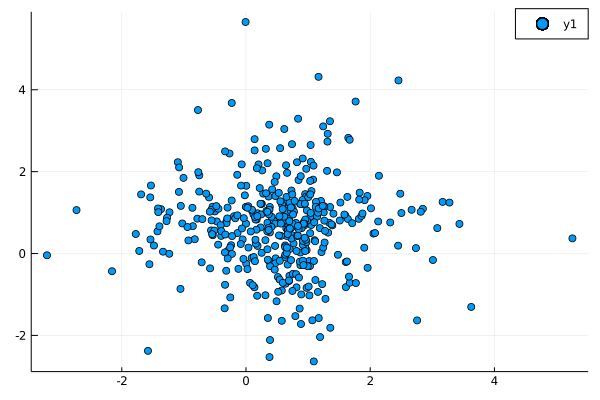

In [7]:
using Plots
scatter(X[1,:], X[2,:])

1-element Array{Float64,1}:
 0.016057990346977687

In [9]:
evaluate(Hk_old.I, X);

In [10]:
J = 0.0
dJ = zeros(Nψ)
@btime J = negative_log_likelihood!($J, $dJ, getcoeff($Hk_old), $S, $Hk_old, $X)
dJ

  54.929 μs (1249 allocations: 72.97 KiB)


10-element Array{Float64,1}:
 -0.16518288177126236
 -0.06929968984860686
 -0.11978266988347296
  0.015366672724817189
 -0.3368758040073704
 -0.05553628780462705
 -0.22853579664856136
  0.0980862060366478
 -0.008584515450656645
 -0.12615268995545434

In [53]:
J = 0.0
dJ = zeros(Nψ)
@btime J = negative_log_likelihood!($J, $dJ, getcoeff($Hk_old), $S, $Hk_old, $X)
dJ

  823.393 μs (1303 allocations: 2.07 MiB)


10-element Array{Float64,1}:
 -0.36139320249835916
 -0.23552498560172141
 -0.22007867902838665
  0.0035319909468692007
 -0.18014024857684413
 -0.1475744620019626
 -0.12284871796624346
  0.08426148499972017
  0.10706601427417024
 -0.002773441681363029

In [17]:
@btime greedyfit($Hk_old, $X, 6; verbose = false);

  4.853 ms (110567 allocations: 6.74 MiB)


In [16]:
@btime Hk_new, train_error, valid_error = greedyfit(Hk_old, X, 6; verbose = false);

  0.009393 seconds (110.57 k allocations: 6.737 MiB)


In [10]:
getidx(Hk_new)

6×2 Array{Int64,2}:
 0  0
 1  0
 2  0
 0  1
 3  0
 1  1

In [10]:
train_error

7-element Array{Float64,1}:
 1.3172777885451104
 1.2274888293485362
 1.1142726775809417
 1.046903969351235
 0.9895934271488671
 0.8502240638418765
 0.6209131553307563

In [187]:
negative_log_likelihood!(0.0, nothing, getcoeff(Hk_old), S, Hk_old, X)
getreducedmargin(zeros(Int64,0,2))

0×0 Array{Int64,2}

In [185]:
S = Storage(Hk_old.I.f, X)
coeff0 = getcoeff(Hk_old)
@show coeff0

res = Optim.optimize(Optim.only_fg!(negative_log_likelihood!(S, Hk_old, X)), coeff0, Optim.BFGS())
Optim.minimizer(res)
res

coeff0 = [0.0]


 * Status: success

 * Candidate solution
    Final objective value:     1.227489e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 3.89e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.80e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.02e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.72e-07 ≰ 0.0e+00
    |g(x)|                 = 6.29e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    8
    ∇f(x) calls:   8


In [183]:
evaluate(Hk_old.I, X)

8-element Array{Float64,1}:
  1.43021
  0.607224
  0.249277
  0.915629
  0.415874
  1.01672
 -0.918205
 -1.00445

train_error[1] = 1.3172777885451104
reduced_margin = [0 1; 1 0]
coeff0 = [0.0]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validatio

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training e

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852

Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res)

getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3

Excessive output truncated after 524347 bytes.


coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.3911852989111255]
Optim.minimizer(res) = [-1.3911852989111255]
getcoeff(Hk) = [-1.3911852989111255]
0 terms - Training error: 1.2274888293485362, Validation error: 1.0729544313674289
coeff0 = [-1.391185

In [13]:
    Nx = 2
    Ne = 8
    m = 5
    ens = EnsembleState(Nx, Ne)

    ens.S .=  [0.267333   1.43021;
              0.364979   0.607224;
             -1.23693    0.249277;
             -2.0526     0.915629;
             -0.182465   0.415874;
              0.412907   1.01672;
              1.41332   -0.918205;
              0.766647  -1.00445]';
    X = ens.S

    idx = [0 0; 0 1; 1 0; 0 2; 2 0; 1 1]

    coeff = [ -0.9905841755746164;
          0.6771992097558741;
         -2.243695806805015;
         -0.34591297359447354;
         -1.420159186008486;
         -0.5361337327704369]

    Hk_old = HermiteMapk(m, Nx, idx, coeff; α = 1e-6);

    S = Storage(Hk_old.I.f, X)

    dJ_old = zeros(6)
    J_old = 0.0
    @time J_old = negative_log_likelihood!(J_old, dJ_old, getcoeff(Hk_old), S, Hk_old, X)

    @test abs(J_old - 1.639729324892425)<1e-5

    dJt_old  = [0.078019218557750;
               0.034817260498187;
              -0.181070374255429;
              -0.084058665820870;
              -0.073995221010768;
               0.051631902496933]

    @test norm(dJ_old - dJt_old)<1e-5



    reduced_margin0 = getreducedmargin(getidx(Hk_old))
    idx_old0 = getidx(Hk_old)
    idx_new0 = vcat(idx_old0, reduced_margin0)

    # Define updated map
    f_new = ExpandedFunction(Hk_old.I.f.f.B, idx_new0, vcat(getcoeff(Hk_old), zeros(size(reduced_margin0,1))))
    Hk_new = HermiteMapk(f_new; α = 1e-6)
    idx_new, reduced_margin = update_component(Hk_old, X, reduced_margin0, S)

    dJ_new = zeros(10)
    J_new = 0.0
    S = update_storage(S, X, reduced_margin0)
    J_new = negative_log_likelihood!(J_new, dJ_new, getcoeff(Hk_new), S, Hk_new, X)

     Jt_new  = 1.639729324892425
    dJt_new  = [ 0.078019218557750;
                 0.034817260498187;
                -0.181070374255429;
                -0.084058665820870;
                -0.073995221010768;
                 0.051631902496933;
                -0.084059299875320;
                 0.134756912666511;
                 0.000251818300919;
                 0.048468510410649]

    @test abs(J_new -    Jt_new)<1e-5
    @test norm(dJ_new - dJt_new)<1e-5


    @test findmax(abs.(dJ_new[7:10]))[2] == 8-6

    @test idx_new0[8,:] == reduced_margin0[2,:]

    @test reduced_margin == updatereducedmargin(getidx(Hk_old), reduced_margin0, 2)[2]
    @test idx_new == updatereducedmargin(getidx(Hk_old), reduced_margin0, 2)[1]

  0.000129 seconds (929 allocations: 53.328 KiB)


Test Passed

In [78]:
res = Optim.optimize(Optim.only_fg!(negative_log_likelihood!(S, Hk_old, ens.S)), coeff, Optim.BFGS())
coeffopt = Optim.minimizer(res)

1-element Array{Float64,1}:
 -1.144117388080984

In [ ]:
greedyfit